In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import time
from scipy.optimize import minimize, approx_fprime
import matplotlib as mpl
from scipy.integrate import solve_ivp

In [2]:
G = 6.67259e-8 # dyne cm2 g-2
c = 2.99792458e10 # cms-1
n_den = 2.3e14
km2cm = 1e5
msun = 1.98847e33
path = "2205.02081/SLY4.csv"

def df_to_ep(df):
    e_den = df.energy_densityc2
    e_den_normed = e_den#/n_den
    p = df.pressurec2
    e_den_normed = e_den_normed*((2.99792458e10)**2)
    pressure = p*((2.99792458e10)**2)
    return e_den_normed.to_numpy(), pressure.to_numpy()
### EOS DATA ###
def get_ep(e, p):
    f_e_smooth = interp1d(p, e, fill_value="extrapolate", kind = "cubic", bounds_error=False)
    return f_e_smooth
def get_pe(p, e):
    f_e_smooth = interp1d(e, p, fill_value=(0, 0), kind = "cubic", bounds_error=True)
    return f_e_smooth

# Load EOS
df = pd.read_csv(path)
e_arr, p_arr = df_to_ep(df)

if path == "eos_data/sly.csv":
    e_arr, p_arr = e_arr[int(0.1*len(e_arr)):], p_arr[int(0.1*len(e_arr)):]

if path == "eos_data/nl3cr.csv":
    pass

EOS = get_ep(e_arr, p_arr)

In [3]:
def dedP_helper(p_arr, e_arr):
    return np.gradient(e_arr, p_arr), e_arr

def dedP(p_arr, e_arr):
    dedp_helper, e_arr = dedP_helper(p_arr, e_arr)
    return interp1d(e_arr, dedp_helper, fill_value="extrapolate", kind = "linear")

dedp = dedP(p_arr, e_arr)

def drhodP(e_arr, dedp = dedp):
    return (c**-2) * dedp(e_arr)

In [4]:
def _b(r, m):
    return G*m/((c**2)*r)
def _lamda(r, m):
    return np.log(1/(1-2*_b(r,m)))
def _Q(r, p, m):
    frac = (c**-4) * (4 * np.pi * G * (r**2) * p)
    return _b(r,m) + frac    
def _dvdr(r, p, m):
    return (2/r) * np.exp(_lamda(r,m)) * _Q(r, p, m)

In [5]:
# # DIMENSIONS CHECKED
# def _dMdr(r, e):
#     return 4 * np.pi * r**2 * (e/(c**2))

# DIMENSIONS CHECKED
def _dPdr(r, P, M, e):    
    # dphidr (From other cowling: arXiv1012.4042)
    num = (M+4*np.pi*(r**3)*P/(c**2))
    dem = r * (r-2*G*M/(c**2))
    return -1 * (e+P) * G/(c**2) * num/dem

# def _dPdr(r, P, M, e):
#     factor = -G/(c**2) 
#     term1 = (e+P) 
#     term2 = (M+4*np.pi*(r**3)*P/(c**2))
#     term3 = r * (r-2*G*M/(c**2))
#     return factor * (term1 * term2)/term3
    
def _dMdr(r, e):
    return 4 * np.pi * r**2 * (e/(c**2))

In [6]:
# DIMENSIONS CHECKED
def _dWdr(r, W, U, v, l, m, p, c_ad2_inv, omega, lamda, Q):
    term1 = -1*(l+1)*( W - l * np.exp(v + lamda/2) * U)
    frac = -1 * (omega*r)**2 * np.exp(lamda/2)*(c_ad2_inv)
    term2 = frac * (U - np.exp(lamda/2)*Q*W*(c**2)/((omega*r)**2))
    dWdlnr = term1 + term2
    dWdr = 1/r * dWdlnr
    return dWdr

# DIMENSIONS CHECKED
def _dUdr(r, W, U, v, lamda, l):
    dUdlnr = np.exp(lamda/2 - v) * (W - l*np.exp(v-lamda/2)*U)
    dUdr = 1/r * dUdlnr
    return dUdr

In [7]:
def coupledTOV(r, VEC, init_params):
    p, m, v, W, U = VEC
    EOS, l, omega, p_min, p_max = init_params
    if p < p_min: 
        return [0, 0, 0, 0, 0]
    if p > p_max: 
        return [0, 0, 0, 0, 0]
    lamda = _lamda(r, m)
    Q = _Q(r, p, m)
    e = EOS(p) 
    c_ad2_inv = drhodP(e)
    dPdr = _dPdr(r, p, m, e)
    dMdr = _dMdr(r, e)
    dvdr = _dvdr(r, p, m)
    dWdr = _dWdr(r, W, U, v, l, m, p, c_ad2_inv, omega, lamda, Q)
    dUdr = _dUdr(r, W, U, v, lamda, l)
    return [dPdr, dMdr, dvdr, dWdr, dUdr]

In [8]:
# DIMENSIONED CHECKED
def boundary_wu(r_R, m_R, omega, w_R, u_R):
    frac1 = (omega**2 * r_R ** 3)/(G*m_R)
    return -frac1 * np.sqrt(1-(2*G*m_R)/(r_R * (c**2))) + w_R/u_R

In [9]:
# Initial Conditions

def initial_conditions(e_arr, p_arr, EOS, k = -2):
    km2cm = 1e5
    r_i = 1
    p0 = p_arr[k]
    e0 = EOS(p0)
    p_c = p0 - 2 * np.pi * (G/(c**4)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3
    e_c = EOS(p_c)
    m0 = e_c/(c**2) * 4/3 * np.pi * r_i**3
    omega = 2e3*(2*np.pi) #Arbitrary guess
    l=2
    v0 = -1 # Two step integration optimization: similar to phi previously.
    W0 = 1
    U0 = W0/(l * np.exp(v0))
    p_min = max(0, min(p_arr))
    p_max = max(p_arr) 

    init_VEC = [p_c, m0, v0, W0, U0]
    init_params = [EOS, l, omega, p_min, p_max]
    init_t = [r_i, 20.01 * km2cm]
    eval_t = np.linspace(r_i, 20 * km2cm, 100000)
    return km2cm, r_i, p0, e0, p_c, e_c, m0, omega, l, v0, W0, U0, p_min, p_max, init_VEC, init_params, init_t, eval_t

km2cm, r_i, p0, e0, p_c, e_c, m0, omega, l, v0, \
W0, U0, p_min, p_max, init_VEC, init_params, \
init_t, eval_t = initial_conditions(e_arr, p_arr, EOS)

# SOLVE COUPLED ODE ANOTHER WAY HERE.
sol = solve_ivp(fun = coupledTOV, 
               t_span = init_t,
               y0 = init_VEC,
               args = [init_params],
               method = "Radau",
               t_eval = eval_t)

def surface_conditions(sol):
    p_total = sol.y[0]
    try: 
        surface_idx = np.where(np.diff(p_total) == 0)[0][0] - 1
    except:
        surface_idx = len(sol.y[0])
    p, m, v, w, u = sol.y[:, :surface_idx]
    r_arr = sol.t[:surface_idx]

    max_idx = np.argmax(m)
    m_R = m.max() # In units of msun
    r_R = r_arr[max_idx] # In units of km
    p_R = p[max_idx] #cgs
    ec_R = EOS(p_R) #cgs
    v_R = v[max_idx]
    w_R = w[max_idx]
    u_R = u[max_idx]
    return p, m, v, w, u, r_arr, max_idx, m_R, r_R, p_R, ec_R, u_R, v_R, w_R

p, m, v, w, u, r_arr, max_idx, m_R, r_R, p_R, ec_R, \
u_R, v_R, w_R = surface_conditions(sol)

print("== First Integration == ")
print(f"Star has mass {m_R/msun:.3f} Msun and radius {r_R/km2cm:.3f}km")
print(f"Interior Surface: {np.exp(v_R):.8f}")
print(f"Exterior Surface: {(1-2*G*m_R/(c**2*r_R)):.8f}")
print(f"v0 Round 1: {v0}")
print(f"Lamda Round 2: {_lamda(r_R, m_R)}")
print(f"Boundary Term: {boundary_wu(r_R, m_R, omega, w_R, u_R)}")

v_ext = -_lamda(r_R, m_R)
v_int = v_R #At surface
delta_v = v_int - v_ext
v0 =  v0 - delta_v
U0 = W0/(l * np.exp(v0))
init_VEC = [p_c, m0, v0, W0, U0]

time.sleep(0.2)

# SOLVE COUPLED ODE ANOTHER WAY HERE.
sol = solve_ivp(fun = coupledTOV, 
               t_span = init_t,
               y0 = init_VEC,
               args = [init_params],
               method = "Radau",
               t_eval = eval_t)

p, m, v, w, u, r_arr, max_idx, m_R, r_R, p_R, ec_R, \
u_R, v_R, w_R = surface_conditions(sol)

print()
print("== Corrected Integration == ")
print(f"Star has mass {m_R/msun:.3f} Msun and radius {r_R/km2cm:.3f}km")
print(f"Interior Surface: {np.exp(v_R):.8f}")
print(f"Exterior Surface: {(1-2*G*m_R/(c**2*r_R)):.8f}")
print(f"v0 Round 2: {v0}")
print(f"Lamda Round 2: {_lamda(r_R, m_R)}")
print(f"Boundary Term: {boundary_wu(r_R, m_R, omega, w_R, u_R)}")

== First Integration == 
Star has mass 1.973 Msun and radius 8.813km
Interior Surface: 3.40331159
Exterior Surface: 0.33913354
v0 Round 1: -1
Lamda Round 2: 1.0813613305607146
Boundary Term: 5.268431157833908

== Corrected Integration == 
Star has mass 1.973 Msun and radius 8.831km
Interior Surface: 0.33910275
Exterior Surface: 0.34046919
v0 Round 2: -3.30611028602224
Lamda Round 2: 1.0774306537057403
Boundary Term: 0.05663937795823756


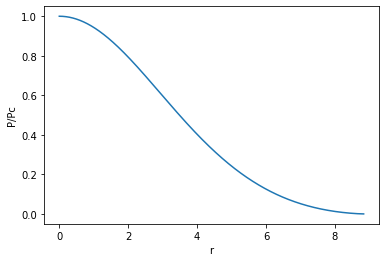

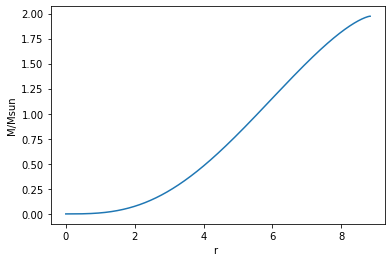

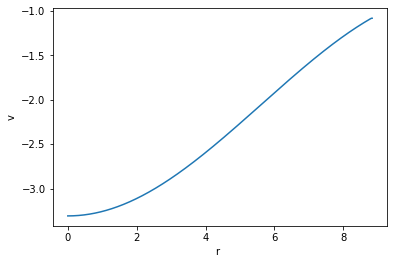

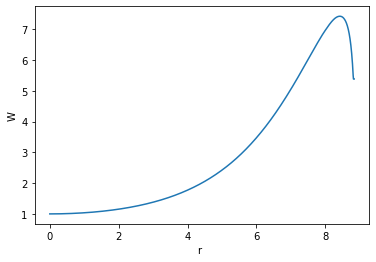

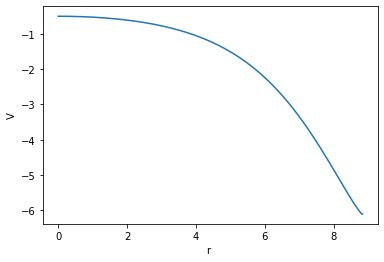

In [10]:
r_arr = r_arr/km2cm

plt.figure()
plt.plot(r_arr, p/p_c)
plt.xlabel("r")
plt.ylabel("P/Pc")

plt.figure()
plt.plot(r_arr, m/msun)
plt.xlabel("r ")
plt.ylabel("M/Msun")
plt.show()

plt.figure()
plt.plot(r_arr, v)
plt.xlabel("r ")
plt.ylabel("v")
plt.show()

plt.figure()
plt.plot(r_arr, w)
plt.xlabel("r ")
plt.ylabel("W")
# plt.xlim(11, r_R/km2cm)
plt.show()

plt.figure()
plt.plot(r_arr, -u*np.exp(v))
plt.xlabel("r ")
plt.ylabel("V")
# plt.xlim(11, r_R/km2cm)
plt.show()

<IPython.core.display.Javascript object>


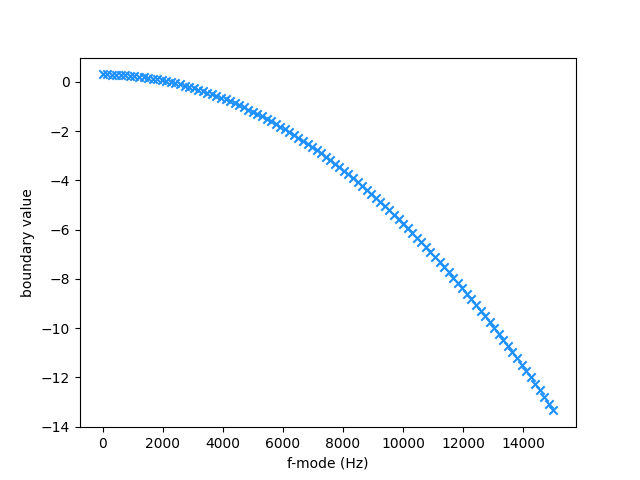

In [11]:
# Delete when shifting over to python
old_backend = mpl.get_backend() 
%matplotlib notebook 
# ====================================================================================
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()
plt.xlabel("f-mode (Hz)")
plt.ylabel("boundary value")

def plot_boundary(omega, p = p, EOS = EOS):
    # Repeat integration

    # Integrate
    sol = solve_ivp(fun = coupledTOV, 
                   t_span = init_t,
                   y0 = init_VEC,
                   args = [init_params],
                   method = "Radau",
                   t_eval = eval_t)

    p, m, v, w, u, r_arr, max_idx, m_R, r_R, p_R, ec_R, \
    u_R, v_R, w_R = surface_conditions(sol)
    
    bc1 = boundary_wu(r_R, m_R, omega, w_R, u_R)
    ax.scatter(omega/(2*np.pi), bc1, color = "dodgerblue", marker = "x")
    fig.canvas.draw()
    return None

omega_guess = np.linspace(0.01*(2*np.pi), 15e3*(2*np.pi), int(1e2))
    
for omega in tqdm(omega_guess):
    plot_boundary(omega)

mpl.use(old_backend) # Delete when shifting over to python